In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
import tensorflow as tf
import pickle
import sys
import yaml

from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Flatten, TimeDistributed, Bidirectional
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
from keras.utils import plot_model
from keras import optimizers
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.models import load_model
from sklearn import preprocessing
from copy import deepcopy

import datetime
import math
import hashlib
import time
import os
from datagenerator import DataGenerator

# add
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0" #"1" #  # specify which GPU(s) to be used

Using TensorFlow backend.


In [2]:
#Disable randomization
import random
seed_value=2020 #10 #
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
random.seed(seed_value)

# add
config = tf.ConfigProto() 
config.gpu_options.allow_growth = True 
# # sess = tf.Session(config=config) 
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

In [3]:
def loadConfig():
#     with open('/home/wesleyjtann/ddos_research/test/light_config_b.yaml', "r") as ymlfile:
    with open('./light_config.yaml', "r") as ymlfile: #GE, hulk, slowhttp, slowloris, heartbleed
        cfg = yaml.load(ymlfile)
    return cfg

config = loadConfig()
# artefact = 'artefact' #'artefact_b' #

/home/wesleyjtann/miniconda3/envs/ddos/lib/python3.7/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


## Helper functions

In [4]:
def prepare_sentence(seq, maxlen, tokenizer):
    # Pads seq and slides windows
    seq = seq[:maxlen]
    seqX = np.append(tokenizer.word_index['<sos>'], seq)
    seqY = np.append(seq, tokenizer.word_index['<eos>'])

    x= pad_sequences([seqX],
        maxlen=maxlen+1,
        padding='post')[0]  # Pads before each sequence

    y= pad_sequences([seqY],
        maxlen=maxlen+1,
        padding='post')[0]  # Pads before each sequence

    return [x], [y]


def getTokenizer(df_arr) :
    ### Dictionary for Normal ###
    tokenizer = Tokenizer(filters='', split='<sep>', oov_token='<OTHERS>' ,lower=True)
    
    for df in df_arr :
        tokenizer.fit_on_texts(df['Input'].values)

    tokenizer.fit_on_texts(['<SOS>'])
    tokenizer.fit_on_texts(['<EOS>'])

    return tokenizer

# def createGeneratorData(df, tokenizer, max_len) :
#     #Prepare training for normal model
#     x = []
#     y = []

#     for seq in df['Input']:
#         x_windows, y_windows = prepare_sentence(seq, max_len, tokenizer)
#         x += x_windows
#         y += y_windows
#     x = np.array(x)
#     y = np.array(y)  # The word <PAD> does not constitute a class

#     x.shape = [len(x), max_len + 1, 1]
#     y.shape = [len(y), max_len + 1, 1]

#     return x, y

def prepare_sentence_classification(seq, maxlen, tokenizer):
    # Pads seq and slides windows
    seq = seq[:maxlen]
#     seqX = np.append(seq, tokenizer.word_index['<eos>'])
    seqX = np.append(tokenizer.word_index['<sos>'], seq)
    seqX = np.append(seqX, tokenizer.word_index['<eos>'])

    x= pad_sequences([seqX],
        maxlen=maxlen+2,
        padding='post')[0]  # Pads before each sequence

    return [x]


def create_input_data(df, tokenizer, max_len):
    #Prepare training for normal model
    x=[]; y=[]
    for index, row in df.iterrows():
        x_windows = prepare_sentence_classification(row['Input'], max_len, tokenizer)
#         y_labels = row['Label']
        y_labels = row['Attack']
#         x += x_windows
        x.append(x_windows)
        y.append(y_labels)
        
    x = np.array(x)
    y = np.array(y)
#     x.shape = [len(x), max_len+2, 1]
    x = np.reshape(x, (len(x), (max_len+2)))#, 1))

    return x, y

## Loading CIC Friday dataset

##### Training set

In [5]:
config['metadata']['uniqueID'] + '/' + config['metadata']['artefact']

'ids_test3/artefact'

In [6]:
    # # N1 data
    # df_normal = pd.read_csv(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'N1.csv')
## new normal = atk data
df_normal = pd.read_csv(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'A1_full.csv')
print("size of normal data: ", len(df_normal))
# df_normal.head()

size of normal data:  50000


In [7]:
online = True
counter = False #True # '''False=no countermeasure'''

In [8]:
if counter is False:
    print("No countermeasure")
    # Entire train atk set. 
    if online is True :
        count = 0
        df_attack_interval = []
        while(True) :
            if not os.path.isfile(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'A1_' + str(count) + '.csv') :
                break
            df_attack = pd.read_csv(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'A1_' + str(count) + '.csv')
            df_attack_interval.append(df_attack)
            count = count + 1
    else :
        df_attackfull = pd.read_csv(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'A1_full.csv')


    for x in df_attack_interval :
        print("size of full attack data: ", len(x))

else:
    print("Use countermeasure")
    # # Online Q interval data (vary 1--3)
    np.random.seed(2022)

    if online is True :
        count = 0
    #     lengths = []
        df_attack_interval = []

        ## initial attack chunk A_0 (first 5 mins)
        interval_range = 5
        df_attack = pd.concat((pd.read_csv(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'A1_' + str(i) + '.csv') for i in range(interval_range)))
        count = count + 1
        df_attack_interval.append(df_attack)

        while(True) :
            if not os.path.isfile(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'A1_' + str(interval_range) + '.csv'):
                break

            next_range = np.random.randint(low=1, high=4)
            print("next range: ",next_range)
            max_range = 12
            if (interval_range+next_range) > max_range:
                if (interval_range == max_range):
                    next_range = 1
                else:
                    next_range = (max_range+1)-interval_range

            df_attack = pd.concat((pd.read_csv(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'A1_' + str(i) + '.csv') for i in range(interval_range,interval_range+next_range)))
            interval_range = interval_range+next_range

            df_attack_interval.append(df_attack)
            count = count + 1

No countermeasure
size of full attack data:  2000
size of full attack data:  2000
size of full attack data:  2000
size of full attack data:  2000
size of full attack data:  2000
size of full attack data:  2000
size of full attack data:  2000
size of full attack data:  2000
size of full attack data:  2000
size of full attack data:  2000
size of full attack data:  2000
size of full attack data:  2000
size of full attack data:  2000


In [9]:
# make attack ratio of train data if available.
ratio = 0.5 #0.8 #0.2
df_attack_interval2 = []
for df_attackfull in df_attack_interval :
    df_attacksmall = df_attackfull[-int(len(df_normal)/ratio - len(df_normal)):]
    print("size of smaller attack data: ", len(df_attacksmall))
    df_attack_interval2.append(df_attacksmall)
df_attack_interval = df_attack_interval2

size of smaller attack data:  2000
size of smaller attack data:  2000
size of smaller attack data:  2000
size of smaller attack data:  2000
size of smaller attack data:  2000
size of smaller attack data:  2000
size of smaller attack data:  2000
size of smaller attack data:  2000
size of smaller attack data:  2000
size of smaller attack data:  2000
size of smaller attack data:  2000
size of smaller attack data:  2000
size of smaller attack data:  2000


In [10]:
# add labels for evaluation
df_attacksmall['Attack'] = 1
df_normal['Attack'] = 0

# Join and shuffle train attack and normal data
#df_train = df_normal.append(df_attacksmall).sample(frac=1, replace=False, random_state=39).reset_index(drop=True)
# df_train =df_normal # df_attacksmall #
#print("size of df_train: ", len(df_train))

df_normal['Attack'] = 0

df_train_arr = []
for df_attacksmall in df_attack_interval :
    df_attacksmall['Attack'] = 1
    df_normalsmall = df_normal.sample(n = int(len(df_attacksmall)*1), replace=False, random_state=39)
    df_train = df_normalsmall.append(df_attacksmall).sample(frac=1, replace=False, random_state=39).reset_index(drop=True)
    df_train_arr.append(df_train)

for x in df_train_arr :
    print("size of df_train: ", len(x))

    

size of df_train:  4000
size of df_train:  4000
size of df_train:  4000
size of df_train:  4000
size of df_train:  4000
size of df_train:  4000
size of df_train:  4000
size of df_train:  4000
size of df_train:  4000
size of df_train:  4000
size of df_train:  4000
size of df_train:  4000
size of df_train:  4000


##### Test set

In [11]:
# Entire test set. 
dftest_atk = pd.read_csv(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'GENTEST.csv')
len(dftest_atk)

12506

In [12]:
# make test set 
# dfnorm_test = df_normal[-int(len(df_normal)*.5):] # last 50% of train norm as test
dfnorm_test = df_normal
print(len(dfnorm_test))

ratio = 0.2 #0.2=80% atk , 0.5=50% atk
# dftest_atksmall = dftest_atk[:(int(len(dfnorm_test)/ratio - len(dfnorm_test)))]
dftest_atksmall = dftest_atk[-(int(len(dfnorm_test)/ratio - len(dfnorm_test))) : ]
# add labels for evaluation
dftest_atksmall['Attack'] = 1
print("size of smaller attack data: ", len(dftest_atksmall))

# join and shuffle train attack and normal data
df_test = dfnorm_test.append(dftest_atksmall).sample(frac=1, replace=False, random_state=39).reset_index(drop=True)
print("size of df_test: ", len(df_test))

# # Saving test set
# df_test.to_csv(config['metadata']['uniqueID'] + '/' + 
#                     config['metadata']['artefact'] + '/' + 'TEST.csv', index=False)

50000
size of smaller attack data:  12506
size of df_test:  62506


##### ==================== ADD ====================

In [13]:
df_test = dftest_atksmall.sample(frac=1, replace=False, random_state=39).reset_index(drop=True)
print("size of df_test: ", len(df_test))

size of df_test:  12506


In [14]:
# resetting attack labels. attacker0='172.16.0.1'
df_test['Attack'] = 0

attacker1='999.16.30.0'; victim='192.168.10.50' # mimic attacker
indexNames = df_test[(df_test['Source IP'] == attacker1)].index

df_test['Attack'][indexNames] = 1
# .drop(indexNames , inplace=True)
# len(df_test_original)

/home/wesleyjtann/miniconda3/envs/ddos/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [15]:
sum(df_test['Attack'] == 1)

10000

### Prepare data

In [16]:
max_len = config['SEQUENCELENGTH']

tokenizer = getTokenizer(df_train_arr)  

In [17]:
def prep_modelinputs(df, max_len, tokenizer):
    df_embedded = df.copy()
    df_embedded['Input'] = tokenizer.texts_to_sequences(df['Input'].values)
#     # Shuffle the data order
#     df_embedded_shuf = df_embedded.sample(frac=1, random_state=42, replace=False)

    # Extract inputs and labels
    df_embedded_shuf = df_embedded
    X_tmp, y_tmp = create_input_data(df_embedded_shuf, tokenizer, max_len)
    # Convert format for training  
    y_tmp = to_categorical(y_tmp, num_classes=2)
    return X_tmp, y_tmp

In [18]:
X_norm, y_norm = prep_modelinputs(df_normal, max_len, tokenizer)
print(X_norm.shape, y_norm.shape)

(50000, 18) (50000, 2)


In [19]:
xtrainytrain_arr=[]
for x in df_train_arr:
    X_train, y_train = prep_modelinputs(x, max_len, tokenizer)
    print(X_train.shape, y_train.shape)
    xtrainytrain_arr.append((X_train, y_train))


(4000, 18) (4000, 2)
(4000, 18) (4000, 2)
(4000, 18) (4000, 2)
(4000, 18) (4000, 2)
(4000, 18) (4000, 2)
(4000, 18) (4000, 2)
(4000, 18) (4000, 2)
(4000, 18) (4000, 2)
(4000, 18) (4000, 2)
(4000, 18) (4000, 2)
(4000, 18) (4000, 2)
(4000, 18) (4000, 2)
(4000, 18) (4000, 2)


In [20]:
X_test, y_test = prep_modelinputs(df_test, max_len, tokenizer)
print(X_test.shape, y_test.shape)

(12506, 18) (12506, 2)


In [21]:
# X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

for (X_train, y_train) in xtrainytrain_arr :
    print("Number transactions X_train dataset: ", X_train.shape)
    print("Number transactions y_train dataset: ", y_train.shape)
    
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

for (X_train, y_train) in xtrainytrain_arr :
    print("Training set, counts of label '0': {}".format(int(np.sum(y_train, axis=0)[0])))
    print("Training set, counts of label '1': {}".format(int(np.sum(y_train, axis=0)[1])))
print("Test set, counts of label '0': {}".format(int(np.sum(y_test, axis=0)[0])))
print("Test set, counts of label '1': {}".format(int(np.sum(y_test, axis=0)[1])))

Number transactions X_train dataset:  (4000, 18)
Number transactions y_train dataset:  (4000, 2)
Number transactions X_train dataset:  (4000, 18)
Number transactions y_train dataset:  (4000, 2)
Number transactions X_train dataset:  (4000, 18)
Number transactions y_train dataset:  (4000, 2)
Number transactions X_train dataset:  (4000, 18)
Number transactions y_train dataset:  (4000, 2)
Number transactions X_train dataset:  (4000, 18)
Number transactions y_train dataset:  (4000, 2)
Number transactions X_train dataset:  (4000, 18)
Number transactions y_train dataset:  (4000, 2)
Number transactions X_train dataset:  (4000, 18)
Number transactions y_train dataset:  (4000, 2)
Number transactions X_train dataset:  (4000, 18)
Number transactions y_train dataset:  (4000, 2)
Number transactions X_train dataset:  (4000, 18)
Number transactions y_train dataset:  (4000, 2)
Number transactions X_train dataset:  (4000, 18)
Number transactions y_train dataset:  (4000, 2)
Number transactions X_train da

### Model

In [22]:
vocab_size=[len(tokenizer.word_index)] 
input_emb_dim = config['MODELPARAMS']['INPUT_EMBED_DIM'] #512
lstm_emb_dim = config['MODELPARAMS']['LSTM_DIM'] #300
print("vocab_size: ", vocab_size)

vocab_size:  [253]


In [23]:
model = Sequential()
model.add(Embedding(vocab_size[0] + 1, input_emb_dim, input_length=X_train.shape[1]))
model.add(LSTM(lstm_emb_dim, return_sequences=True)) # dropout=0.2, recurrent_dropout=0.2))
model.add(LSTM(lstm_emb_dim))
# model.add(TimeDistributed(Dense(2, activation='sigmoid')))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer=optimizers.adam(lr=0.005), 
              loss='binary_crossentropy', metrics=['acc']) #lr=0.005 config['MODELPARAMS']['LEARNING_RATE_P']

print(model.summary())






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 18, 512)           130048    
_________________________________________________________________
lstm_1 (LSTM)                (None, 18, 300)           975600    
_________________________________________________________________
lstm_2 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 602       
Total params: 1,827,450
Trainable params: 1,827,450
Non-trainable params: 0
_________________________________________________________________
None


## Full classifier training

history = model.fit(X_train, y_train, epochs=config['TRAININGPARAMS']['EPOCHS_P'], 
                      batch_size=config['TRAININGPARAMS']['BATCH_SIZE'], validation_split=0.2, 
                      callbacks=[EarlyStopping(monitor='val_loss', patience=7, 
                                               mode='auto', min_delta=0.0002)]) #

import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

f = plt.figure(figsize=(15,5))

ax1 = f.add_subplot(121)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.plot(epochs, acc, 'bo', label='Training acc')
ax1.plot(epochs, val_acc, 'b', label='Validation acc')
ax1.legend()
ax1.title.set_text('Training and validation accuracy')

ax2 = f.add_subplot(122)
ax2.title.set_text('Generated Synthetic Graph')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.plot(epochs, loss, 'bo', label='Training loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.legend()
ax2.title.set_text('Training and validation loss')

plt.show()

### Evaluate Full classifier model

## Iterative classifier training

In [24]:
iter_model = Sequential()
iter_model.add(Embedding(vocab_size[0] + 1, input_emb_dim, input_length=X_train.shape[1]))
iter_model.add(LSTM(lstm_emb_dim, return_sequences=True)) # dropout=0.2, recurrent_dropout=0.2))
iter_model.add(LSTM(lstm_emb_dim))
# model.add(TimeDistributed(Dense(2, activation='sigmoid')))
iter_model.add(Dense(2, activation='sigmoid'))
iter_model.compile(optimizer=optimizers.adam(lr=0.005), 
              loss='binary_crossentropy', metrics=['acc']) #lr=0.005 config['MODELPARAMS']['LEARNING_RATE_P']

print(iter_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 18, 512)           130048    
_________________________________________________________________
lstm_3 (LSTM)                (None, 18, 300)           975600    
_________________________________________________________________
lstm_4 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 602       
Total params: 1,827,450
Trainable params: 1,827,450
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
keep_thres = 0.5 #0.7 # must be <=0.5
count = 0

#Number of iterations per interval. If want can change to array maybe?
n_epochs = 5 # 3 #10 #

for (X_train, y_train) in xtrainytrain_arr :
    print("Training for interval", count, " ")
    for _ in range(2):
        iter_model.fit(X_train, y_train, epochs=n_epochs, 
                          batch_size=config['TRAININGPARAMS']['ONLINE_BATCH_SIZE'], validation_split=0.2, 
                          callbacks=[EarlyStopping(monitor='val_loss', patience=7, 
                                               mode='auto', min_delta=0.0002)]) #

        y_predscr = iter_model.predict(X_train, batch_size=config['TRAININGPARAMS']['BATCH_SIZE'], verbose=1)
    
        # Sorting y_predscr and X_train
        sorting = np.argsort(-1*y_predscr[:, 1]) # add (-1*) to argsort the second column in descending order 
        ypred_sorted = y_predscr[sorting] 
        Xtrain_sorted = X_train[sorting]
    
        # reduce Xtrain_sorted and ypred_sorted to keep_num size
        print(len(y_predscr))
        keep_num = int(len(y_predscr)*keep_thres)
        print(keep_num)
        Xtrain_atk = Xtrain_sorted[:keep_num,:]
        ytrain_atk = np.vstack((np.zeros(keep_num), np.ones(keep_num))).T #.shape
    
        # randomly choose from X_norm to create new training set
        Xtrain_norm = X_norm[np.random.choice(X_norm.shape[0], size=keep_num, replace=False), :]
        X_train = np.concatenate((Xtrain_atk,Xtrain_norm), axis=0)
        y_train = np.concatenate((ytrain_atk,y_norm[:len(Xtrain_norm)]), axis=0)
    
        # Shuffle new training set
        shuffler = np.random.permutation(len(X_train))
        X_train = X_train[shuffler]
        y_train = y_train[shuffler]
    
    count = count + 1

Training for interval 0  
Train on 3200 samples, validate on 800 samples
Epoch 1/5
3200/3200 [==============================] - 1s 322us/step - loss: 0.6953 - acc: 0.4950 - val_loss: 0.6995 - val_acc: 0.5012
Epoch 2/5
3200/3200 [==============================] - 1s 308us/step - loss: 0.6953 - acc: 0.4922 - val_loss: 0.6982 - val_acc: 0.5012
Epoch 3/5
3200/3200 [==============================] - 1s 331us/step - loss: 0.6929 - acc: 0.5366 - val_loss: 0.6944 - val_acc: 0.5012
Epoch 4/5
3200/3200 [==============================] - 1s 337us/step - loss: 0.6873 - acc: 0.5741 - val_loss: 0.6861 - val_acc: 0.6188
Epoch 5/5
4000/4000 [==============================] - 0s 99us/step
4000
2000
Train on 3200 samples, validate on 800 samples
Epoch 1/5
3200/3200 [==============================] - 1s 330us/step - loss: 0.6279 - acc: 0.7969 - val_loss: 0.6069 - val_acc: 0.8000
Epoch 2/5
3200/3200 [==============================] - 1s 315us/step - loss: 0.5919 - acc: 0.8053 - val_loss: 0.5717 - val_acc:

3200/3200 [==============================] - 1s 357us/step - loss: 0.7648 - acc: 0.5867 - val_loss: 0.7052 - val_acc: 0.5925
Epoch 2/5
3200/3200 [==============================] - 1s 347us/step - loss: 0.6716 - acc: 0.5761 - val_loss: 0.6894 - val_acc: 0.5744
Epoch 3/5
3200/3200 [==============================] - 1s 321us/step - loss: 0.6536 - acc: 0.6169 - val_loss: 0.6844 - val_acc: 0.5787
Epoch 4/5
3200/3200 [==============================] - 1s 328us/step - loss: 0.6416 - acc: 0.6280 - val_loss: 0.6820 - val_acc: 0.5913
Epoch 5/5
4000/4000 [==============================] - 0s 102us/step
4000
2000
Train on 3200 samples, validate on 800 samples
Epoch 1/5
3200/3200 [==============================] - 1s 341us/step - loss: 0.5732 - acc: 0.7080 - val_loss: 0.5573 - val_acc: 0.7412
Epoch 2/5
3200/3200 [==============================] - 1s 328us/step - loss: 0.5569 - acc: 0.7233 - val_loss: 0.5499 - val_acc: 0.7356
Epoch 3/5
3200/3200 [==============================] - 1s 348us/step - los

3200/3200 [==============================] - 1s 331us/step - loss: 0.6830 - acc: 0.5684 - val_loss: 0.6785 - val_acc: 0.5594
Epoch 3/5
3200/3200 [==============================] - 1s 322us/step - loss: 0.6648 - acc: 0.5958 - val_loss: 0.6879 - val_acc: 0.5569
Epoch 4/5
3200/3200 [==============================] - 1s 332us/step - loss: 0.6635 - acc: 0.6072 - val_loss: 0.6750 - val_acc: 0.5750
Epoch 5/5
4000/4000 [==============================] - 0s 98us/step
4000
2000
Train on 3200 samples, validate on 800 samples
Epoch 1/5
3200/3200 [==============================] - 1s 324us/step - loss: 0.5929 - acc: 0.7355 - val_loss: 0.5704 - val_acc: 0.7319
Epoch 2/5
3200/3200 [==============================] - 1s 341us/step - loss: 0.5350 - acc: 0.7553 - val_loss: 0.5231 - val_acc: 0.7338
Epoch 3/5
3200/3200 [==============================] - 1s 329us/step - loss: 0.5048 - acc: 0.7563 - val_loss: 0.5205 - val_acc: 0.7262
Epoch 4/5
3200/3200 [==============================] - 1s 355us/step - loss

In [45]:
X_train.shape

(4000, 18)

### Evaluate Iterative classifier model

In [46]:
# Extract true labels
ytest_true = np.argmax(y_test, axis=1)

In [47]:
accr = iter_model.evaluate(X_test, y_test, batch_size=512)
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(accr[0],accr[1]))

12506/12506 [==============================] - 1s 54us/step
Test set
  Loss: 0.6534
  Accuracy: 0.8330


In [48]:
y_pred = iter_model.predict_classes(X_test, batch_size=512, verbose=1)

12506/12506 [==============================] - 1s 48us/step


In [49]:
y_predscr = iter_model.predict(X_test, batch_size=512, verbose=1)

predpos = np.count_nonzero(y_predscr[:,1] > 0.5)
pred_allpos = predpos / len(y_predscr)
print('Percentage of Positives: {:0.4f}'.format(pred_allpos))

12506/12506 [==============================] - 1s 49us/step
Percentage of Positives: 0.9667


In [50]:
# lr = 0.005
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

print('Accuracy:', accuracy_score(ytest_true, y_pred))
print('Recall:', recall_score(ytest_true, y_pred))
print('Precision:', precision_score(ytest_true, y_pred))
print('F1 score:', f1_score(ytest_true, y_pred))
print('\n clasification report:\n', classification_report(ytest_true, y_pred))
print('\n confusion matrix:\n',confusion_matrix(ytest_true, y_pred))

tn, fp, fn, tp = confusion_matrix(ytest_true, y_pred).ravel()
print(tn, fp, fn, tp)
fpr = fp / (fp+tn)
fpr

Accuracy: 0.8329601791140253
Recall: 1.0
Precision: 0.8271982794275788
F1 score: 0.905428041106433

 clasification report:
               precision    recall  f1-score   support

           0       1.00      0.17      0.29      2506
           1       0.83      1.00      0.91     10000

    accuracy                           0.83     12506
   macro avg       0.91      0.58      0.60     12506
weighted avg       0.86      0.83      0.78     12506


 confusion matrix:
 [[  417  2089]
 [    0 10000]]
417 2089 0 10000


0.8335993615323224

In [51]:
fp_classifier = []    
percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for percent in percentages:
    tau_threshold = percent
    ytau_pred = (y_predscr[:,0] < tau_threshold).astype(int)
    tn_tmp, fp_tmp, fn_tmp, tp_tmp = confusion_matrix(ytest_true, ytau_pred).ravel()
    tn_tmp, fp_tmp, fn_tmp, tp_tmp 
    fpr_tmp = fp_tmp / (fp_tmp+tn_tmp)
    fp_classifier.append(fpr_tmp)
    
fp_classifier.insert(0,0)
fp_classifier

[0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.8335993615323224,
 0.8335993615323224,
 0.8363926576217079,
 0.8363926576217079,
 1.0,
 1.0]

In [52]:
# False negative rate: FNR=1−TPR or FNR=FN/(TP+FN) 
fn_classifier = []    
percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for percent in percentages:
    tau_threshold = percent
#     ytau_pred = (y_predscr[:,0] < (1-tau_threshold)).astype(int)
    ytau_pred = (y_predscr[:,1] > tau_threshold).astype(int)
    tn_tmp, fp_tmp, fn_tmp, tp_tmp = confusion_matrix(ytest_true, ytau_pred).ravel()
    tn_tmp, fp_tmp, fn_tmp, tp_tmp 
    fpr_tmp = fp_tmp / (fp_tmp+tn_tmp)

#     fnr_tmp = 1 - fpr_tmp
    fnr_tmp = fn_tmp / (tp_tmp+fn_tmp)
    fn_classifier.append(fnr_tmp)
    
fn_classifier.insert(0,0)
fn_classifier

[0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]

12506


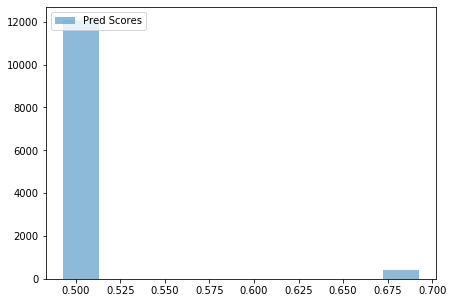

In [34]:
import matplotlib.pyplot as plt

scores = y_predscr[:,1] # classifier atk scores
# def showscore(scores):
fig = plt.figure(figsize=(7,5))
print(len(scores))
plt.hist(scores, bins = 10, alpha=0.5, label='Pred Scores') 
#     plt.hist(scoretype[scores][scoretype['Attack'] == 1], bins = 10, alpha=0.5, label='attacker')
plt.legend(loc='upper left')
plt.show()
    
# showscore(y_predscr) # P scores